In [1]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

In [2]:
class style:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Data extraction

In [14]:
%load_ext autoreload
%autoreload 2
#plt.rcParams['figure.figsize'] = (16,8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def run_dat_extract(data, path, country):
    
    ## Import data
    import pandas as pd

    #_set_params
#     path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
#     country = 'PL'

    # Import Club Customers
    
    df_club = data.loc[data.country_code == country]
       
    ## Munge data
    
    from purchase_prediction.munging_pipeline import (start_pipeline, 
                                                      select_valid_cards, 
                                                      correct_cols, 
                                                      def_types, 
                                                      down_sample,
                                                      correct_timestamps, 
                                                      correct_for_retourned,
                                                      drop_retours,
                                                      assign_customer_type,
                                                      drop_cols
                                             )

    df_club_clean = (df_club
    .pipe(start_pipeline)
    .pipe(select_valid_cards)
    .pipe(correct_cols)            
    .pipe(correct_timestamps)
    .pipe(def_types,
          column_name='turnover_with_vat_euro',
          type=float)
    #.pipe(down_sample, threshold=50000)
    #.pipe(correct_for_retourned) # This steps is very long (should be optimized). Only use if monetary value required.
    .pipe(drop_retours)   
    .pipe(assign_customer_type,label='club')
    )

    print('')
    print('There are ' + str(df_club_clean.groupby(by='customer_salesforce_id').count().shape[0]) + ' club customers.')


    from purchase_prediction.ml_pipeline import (select_recent_members, 
                                                 date_benchmarking, 
                                                 compute_age_recency, 
                                                 rename_cols, 
                                                 select_ml_data, 
                                             )

    from purchase_prediction.ml_pipeline_ecom import (select_receipt_dates_ecom, 
                                                      compute_age_recency_ecom, 
                                                      rename_cols_ecom_ml, 
                                                      add_frequency, 
                                                      select_ml_data_ecom, 
                                                 )
    now_time_reference = '2020-01-01T00'
    df_ml = (df_club_clean
    .pipe(start_pipeline)
#     .pipe(select_recent_members,
#     timestamp_bef='2018-01-01T00',
#     timestamp_aft=now_time_reference,
#     action = "between")
#    .pipe(date_benchmarking, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency,timestamp_ref=now_time_reference)
    .pipe(rename_cols)
    .pipe(select_ml_data)
    )

    lost_customers = df_club_clean.groupby(by='club_card_number').count().shape[0] - df_ml.groupby(by='club_card_number').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for ML pipeline = ' + str(df_ml.groupby(by='club_card_number').count().shape[0]))

    return df_ml#, df_club_clean, df_club

## Model fit & test

In [16]:
def run_model(df_ml):
    # Import models
    from lifetimes import BetaGeoFitter,ParetoNBDFitter
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    #bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

    # Verify that the model is doing a relatively good job at predicting values
    from lifetimes.utils import calibration_and_holdout_data
    # This function creates a summary of each customer over a calibration and holdout period (training and testing)
    # It accepts transaction data, and returns a DataFrame of sufficient statistics.
    summary_cal_holdout = calibration_and_holdout_data(df_ml, 'sfid', 'receipt_issue_date',
                                                        calibration_period_end='2018-10-01',
                                                        observation_period_end='2019-10-01',
                                                        freq='W',
                                                        monetary_value_col = 'monetary_value')

    from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

    bgf.fit(summary_cal_holdout['frequency_cal'], 
            summary_cal_holdout['recency_cal'], 
            summary_cal_holdout['T_cal'])
    plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

    # Model summary
#     print('Model Summary')
#     print(bgf.summary)

    ## Model fit over all data to predict 2020

    # Transform transaction data into customer-based data with three attributes
    from lifetimes.utils import summary_data_from_transaction_data

    summary = summary_data_from_transaction_data(df_ml, 
                                                 'sfid', 
                                                 'receipt_issue_date', 
                                                 observation_period_end='2019-10-01',
                                                 datetime_format = '%Y-%m-%d',
                                                 freq='W',
                                                 monetary_value_col = 'monetary_value')
#     print('Sample of ML data')
#     print(summary.sample(2))
    print('')

    from lifetimes import BetaGeoFitter

    # similar API to scikit-learn and lifelines.
    # I am using some penalizer due to low sample size, see lifetimes documentation.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    print(bgf.summary)

    # Add predicted purchases to summary dataframe
    # Predicted purchases are calculated for a given time window t
    t = 4
    summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                                   (
                                                    t, 
                                                    summary['frequency'], 
                                                    summary['recency'], 
                                                    summary['T']
                                                   )
                                                  )

    from lifetimes.plotting import plot_period_transactions
    plot_period_transactions(bgf)
    return summary

## Run the good stuff

In [17]:
import pandas as pd
import os

In [7]:
path = 'J:\\BoitePos\\Julien_Exchange'
os.chdir(path)

df = pd.read_csv('JULIEN_2020-03-04T15_46_502020-03-04 15-47-54.csv', delimiter=';')

In [8]:
df_test = df.copy()

In [10]:
df_test.columns = [c.lower() for c in df_test.columns]
df_test = (df_test.rename(columns={
    'ctry_code': 'country_code',
    'club_card_code': 'club_card_number', 
    'clbc_salesforce_id': 'customer_salesforce_id', 
    'date_identifier': 'date',
    'club_card_last_date': 'club_card_first_receipt_date', 
    'club_card_init_date': 'club_card_last_receipt_date', 
    'eatkl_biid': 'receipt_id',
    'to_eur': 'turnover_with_vat_euro'
    
                        }
              )
        .drop(columns={'flag_is_sale'})
    )

In [18]:
df_test

,country_code,club_card_number,customer_salesforce_id,date,club_card_first_receipt_date,club_card_last_receipt_date,receipt_id,turnover_with_vat_euro
0,DE,0,0035800000h7I8ZAAU,2018-02-19,2018-04-09,2004-12-20,1215018678,69.980000
1,DE,0,0035800000h7I8ZAAU,2018-03-06,2018-04-09,2004-12-20,1224652632,-69.980000
2,DE,0,0035800000h7I8ZAAU,2018-03-26,2018-04-09,2004-12-20,1246047609,60.980000
3,DE,2,0035800000HXlcDAAT,2018-05-15,2018-05-15,2009-09-21,1342683863,25.990000
4,DE,36,0035800000ud6xuAAA,2018-01-11,2019-11-22,2007-12-04,1187180687,47.990000
...,...,...,...,...,...,...,...,...
37617272,RS,9501333665,0031i00000CldfEAAR,2019-05-18,2020-02-27,2019-05-03,1759882581,31.186883
37617273,RS,9501333665,0031i00000CldfEAAR,2019-05-18,2020-02-27,2019-05-03,1760069137,19.488623
37617274,RS,9501340577,0031i0000073Gz9AAE,2019-08-08,2019-08-08,2019-04-10,1766869694,17.669600
37617275,RS,9501488453,0031i00000EhJCHAA3,2019-11-09,2019-11-09,2019-09-15,1823242706,11.577680


In [11]:
# I miss the column receipt count so I add it manually
df_test = df_test.assign(count_receipts = (df_test.turnover_with_vat_euro>0).astype(int))

In [12]:
summary = pd.DataFrame()
countries = ['DE', 'PL', 'SI', 'SK', 'RS', 'AT', 'CZ', 'HU', 'HR', 'RO']

In [13]:
df_ml_countries = pd.DataFrame()
for i in countries:
    #_set_params
    #path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
    path = 'u:\\Projects\\datasets\\customer_history\\winter_celebration'
    country = i
    print(style.BOLD + style.BLUE + 'Now calculating prediction for ' + country + style.END)
    # extract data
    df_ml = run_dat_extract(data=df_test, path=path, country=country)
    df_ml_countries = df_ml_countries.append(df_ml)

Now calculating prediction for DE
f/ select_valid_cards cleaned: 407 (i.e., 0.0% of initial data) entries from input dataf.

There are 2554930 club customers.
Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 2646983
Now calculating prediction for PL
f/ select_valid_cards cleaned: 155 (i.e., 0.0% of initial data) entries from input dataf.

There are 2137917 club customers.
Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 2221789
Now calculating prediction for SI
f/ select_valid_cards cleaned: 0 (i.e., 0.0% of initial data) entries from input dataf.

There are 126887 club customers.
Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 131845
Now calculating prediction for SK
f/ select_valid_cards cleaned: 7 (i.e., 0.0% of initial data) entries from input dataf.

There are 265841 club customers.
Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 280153
Now calculating prediction for RS
f/

In [14]:
df_ml_countries

,sfid,club_card_number,age_in_weeks,recency_in_weeks,frequency,monetary_value,receipt_issue_date,customer_type
407,0031i00000MIOlpAAH,20151,7.714286,-531.142857,1,43.970000,2018-05-24,club
409,0031i00000MIOlpAAH,20151,7.714286,-531.142857,1,115.960000,2019-03-29,club
411,0031i00000MIOlpAAH,20151,7.714286,-531.142857,1,49.000000,2019-08-01,club
412,0031i00000MIOlpAAH,20151,7.714286,-531.142857,1,39.200000,2019-08-01,club
415,0031i00000MIOlpAAH,20151,7.714286,-531.142857,1,97.970000,2019-10-24,club
...,...,...,...,...,...,...,...,...
37100201,0035800001PqVdjAAF,9500198878,-6.714286,-97.571429,1,74.075700,2019-07-08,club
37100202,0035800001NGdEAAA1,9500259331,-1.285714,-97.142857,1,17.176653,2018-05-06,club
37100203,0031i000001rNN5AAM,9500586527,10.857143,-56.714286,1,34.495161,2019-10-17,club
37100204,0031i00000HYhvBAAT,9500749107,-8.142857,-91.857143,1,76.082760,2019-08-02,club


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.646331  0.000534         0.645285         0.647378
alpha  14.385557  0.014882        14.356389        14.414726
a       0.050229  0.000267         0.049707         0.050752
b       0.789464  0.004391         0.780858         0.798070


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


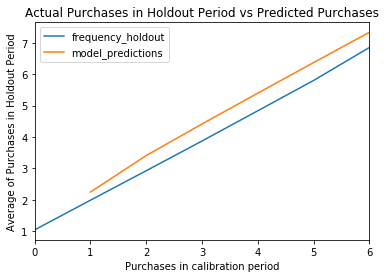

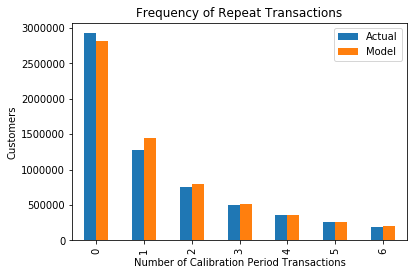

In [15]:
# run model
to_append = run_model(df_ml=df_ml_countries)

to_append = to_append.assign(norm_purchase = normalize(to_append['pred_purch_coming_week=4'])).reset_index()
summary = summary.append(to_append)

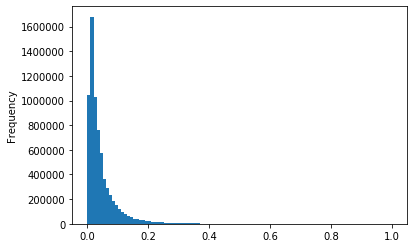

In [16]:
to_append.norm_purchase.plot(kind='hist', bins=100)

In [19]:
to_append.to_csv('output_scores_orsay_all_countries_one_file_06032020.csv')

In [20]:
pwd

'J:\\BoitePos\\Julien_Exchange'

In [12]:
summary.to_csv('PRED_PURCHASE_ALL_COUNTRIES.csv')

In [14]:
summary = pd.read_csv('PRED_PURCHASE_ALL_COUNTRIES.csv')

## Comparison DeFacto

In [40]:
import os
import plotnine as p9
import pandas as pd

def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

path = 'u:\\Projects\\datasets\\customer_history\\DeFacto_scores'
os.chdir(path)
file = 'Orsay_Promo_salesforce_January_2020.csv' # PreSale January 2020
#file = '20190913_Score_Winter_Celebration.csv'   # Winter Celebration October 2019
#file = '20191025_Winter_Presale_Daten_Score.csv' # Winter PreSale November 2019
os.chdir(path)
os.getcwd()

## Import data
files = os.listdir()
df_defacto = pd.read_csv(files[files.index(file)],sep=';', 
                          header = 0,
                          decimal=",",
                          #encoding='Latin-1'
                        )
df_defacto.columns = [c.lower() for c in df_defacto.columns]

df_orsay = summary.copy()
df_orsay = df_orsay.assign(norm_purchase = lambda d: normalize(d['pred_purch_coming_week=4']))
df_orsay.reset_index(level=0, inplace=True)

In [46]:
# merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
#df_defacto.kunde_id = df_defacto.kunde_id.astype('str')
merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
print('We loose ' + str(df_orsay.shape[0] - merged_orsay_defacto_data.shape[0]) + ' customers with DeFacto merging')



print('Correlation coefficients between DeFacto and Orsay scoring:')
print(merged_orsay_defacto_data.corr()['score'])

MemoryError: Unable to allocate array with shape (2, 8880169) and data type object

In [32]:
df_defacto

,kunde_id,kunde_konto_kz_ref_land,kunde_dim_abc,score
0,40289583,RO,4,0.039480
1,40291148,RO,4,0.033108
2,40291800,PL,4,0.039685
3,40291126,DE,4,0.030001
4,40291420,PL,4,0.035346
...,...,...,...,...
7748925,32596219,DE,4,0.030092
7748926,32597359,CZ,3,0.059771
7748927,32603095,PL,4,0.072415
7748928,32834129,PL,3,0.084508


In [ ]:
(p9.ggplot(mapping=p9.aes(x='norm_purchase', y='score'), data=merged_orsay_defacto_data)
+ p9.geom_point( alpha=0.1))

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 13999 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [225]:
# Look for divergent customers
(merged_orsay_defacto_data.loc[(merged_orsay_defacto_data.norm_purchase < 0.1) & (merged_orsay_defacto_data.score > 0.5)]
.sort_values(by='norm_purchase', ascending=True)
)

,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4,norm_purchase,scoringidentifier,score
1612457,0035800000h7Df2AAE,48.0,59.0,91.0,62.116667,0.000031,0.000009,Spring Special 2020,0.592438
1672744,0035800000lSq87AAC,24.0,39.0,85.0,132.846667,0.000083,0.000024,Spring Special 2020,0.611608
1634443,0035800000iBTtBAAW,53.0,62.0,90.0,75.367925,0.000089,0.000026,Spring Special 2020,0.979622
1665312,0035800000kqHhpAAE,42.0,60.0,91.0,118.965000,0.000371,0.000107,Spring Special 2020,0.767284
2221704,0035800001VOn0XAAT,20.0,32.0,70.0,208.754500,0.001315,0.000379,Spring Special 2020,0.507836
...,...,...,...,...,...,...,...,...,...
2204235,0035800001UHKnbAAH,7.0,72.0,72.0,134.661429,0.346945,0.099908,Spring Special 2020,0.732246
1772246,0035800000xgJGVAA2,7.0,72.0,72.0,129.675714,0.346945,0.099908,Spring Special 2020,0.642193
1243630,0035800000HVRCTAA5,7.0,72.0,72.0,89.147993,0.346945,0.099908,Spring Special 2020,0.656836
717284,0035800000Ge3hpAAB,8.0,71.0,82.0,166.848750,0.347262,0.100000,Spring Special 2020,0.507302


# CLV

In [35]:
returning_customers_summary = summary.copy()
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.122942
frequency,0.122942,1.000000


In [36]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1314789 subjects, p: 5.85, q: 1.69, v: 6.93>


In [122]:
clv = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                                              returning_customers_summary['monetary_value']
                  
                                             )

In [38]:
from lifetimes import BetaGeoFitter,ParetoNBDFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
# refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['recency'], 
        returning_customers_summary['T'],
        returning_customers_summary['monetary_value'])

clv_dcf = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=1, # months
    discount_rate=0.01,# monthly discount rate ~ 12.7% annually
    freq = 'W')

In [185]:
clv_to_merge = pd.DataFrame(clv).merge(clv_dcf,on='sfid', how='left').reset_index().rename(columns={'clv': 'clv_dcf',
                                                                                                    0: 'clv'})
clv_to_merge = (clv_to_merge
.assign(clv = lambda d: d['clv'].fillna(value=0))
.assign(clv_dcf = lambda d: d['clv_dcf'].fillna(value=0))
.assign(norm_clv = lambda d: normalize(d['clv']))
.assign(norm_clv_dcf = lambda d: normalize(d['clv_dcf']))
)

In [186]:
merged_final_data = pd.merge(merged_orsay_defacto_data, clv_to_merge, on= 'sfid', how= 'left')

In [216]:
merged_final_data = merged_final_data.assign(overall_score = lambda d: normalize(d.clv * d.norm_purchase))

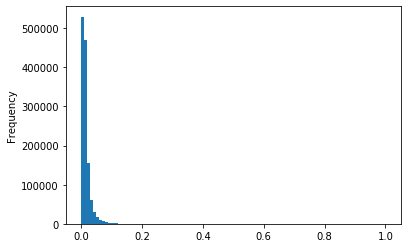

In [221]:
merged_final_data.norm_clv.plot(kind='hist', bins=100)

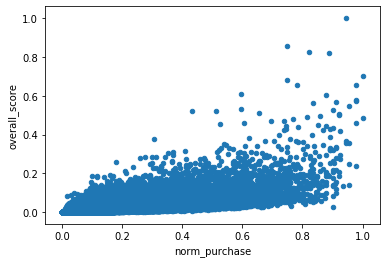

In [218]:
merged_final_data.plot(kind='scatter', x='norm_purchase', y='overall_score')

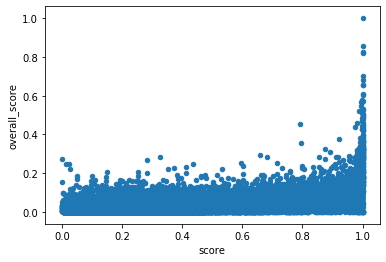

In [219]:
merged_final_data.plot(kind='scatter', x='score', y='overall_score')

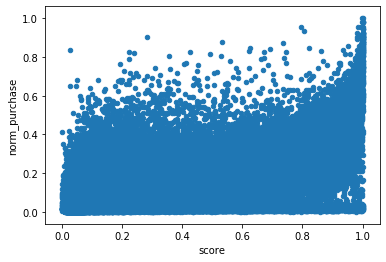

In [215]:
merged_final_data.plot(kind='scatter', x='score', y='norm_purchase')

In [195]:
merged_final_data.columns

Index(['sfid', 'frequency', 'recency', 'T', 'monetary_value',
       'pred_purch_coming_week=4', 'norm_purchase', 'scoringidentifier',
       'score', 'clv', 'clv_dcf', 'norm_clv', 'norm_clv_dcf', 'overall_score'],
      dtype='object')

In [110]:
merged_final_data[['clv', 
                   'clv_dcf', 
                   'norm_clv',
                   'norm_clv_dcf',
                   'overall_score',
                   'overall_score_norm']] = (merged_final_data[['clv', 
                                                               'clv_dcf', 
                                                               'norm_clv', 
                                                               'norm_clv_dcf',
                                                                'overall_score',
                                                                ]]
.fillna(value = 0)
)

In [5]:
merged_final_data.loc[(merged_final_data.norm_purchase < 0.1) & (merged_final_data.clv > 0.1)].mean()

NameError: name 'merged_final_data' is not defined